# Analysis

After running `compare.py` on various sources (chng, nchs, dsew, hhs, quidel), this analysis notebook pinpoints where/when the difference between api and S3 happened.

### Preprocess:

Since compare.py outputs a series of json objects separated by commas instead of valid json file, this following chunk converts all json of this bad form in current dir to good format.

In [1]:
# # Make output file actually valid json by adding brackets
# import glob
# import pandas as pd

# dotjson_files = glob.glob('*.json')

# for dotjson_file in dotjson_files:
#     # Open the file and read it into a string
#     with open(dotjson_file, 'r') as f:
#         content = f.read()

#     # Add the brackets
#     content = '[' + content[:-2] + ']'

#     # Write the string back to the file
#     with open(dotjson_file, 'w') as f:
#         f.write(content)

Read all json files in current dir to a df.

In [2]:

import glob
import pandas as pd

json_files = glob.glob('*.json')

# Read all the JSON files into a list of DataFrames
dfs = [pd.read_json(file) for file in json_files]

# Concatenate all the DataFrames into one
df = pd.concat(dfs, ignore_index=True)
print(df.columns)


Index(['file_name', 'source', 'signal', 'time_value', 'geo_type',
       'dif_row_count', 's3_row_count', 'api_row_count', 'full_dif', 'skip',
       'reason'],
      dtype='object')


In [3]:
df['time_value'] = df['time_value'].fillna(0).astype(int)

## General Analysis
After missingness is taken into account, less than 10% of the files have differences.

In [4]:
print('number of s3 csv files processed by compare.py',len(df))
print('number of s3 csv files with differences found',len(df[df['dif_row_count']!=0]))


number of s3 csv files processed by compare.py 438164
number of s3 csv files with differences found 40440


## Specific Indicators
#### 1. Quidel
Vast majority of quidel s3 files have all rows matching api equivalent.
Smoothed signals have more differences than non-smoothed signals.
2 big spikes in 2022 and throughout mid 2023. 

In [5]:
quidel = df[df["source"]=="quidel"]
# quidel.head()

In [6]:
print(len(quidel[quidel['dif_row_count']!=0]))
print(len(quidel))
print(len(quidel[quidel['dif_row_count']!=0])/len(quidel))

4796
124647
0.038476658082424765


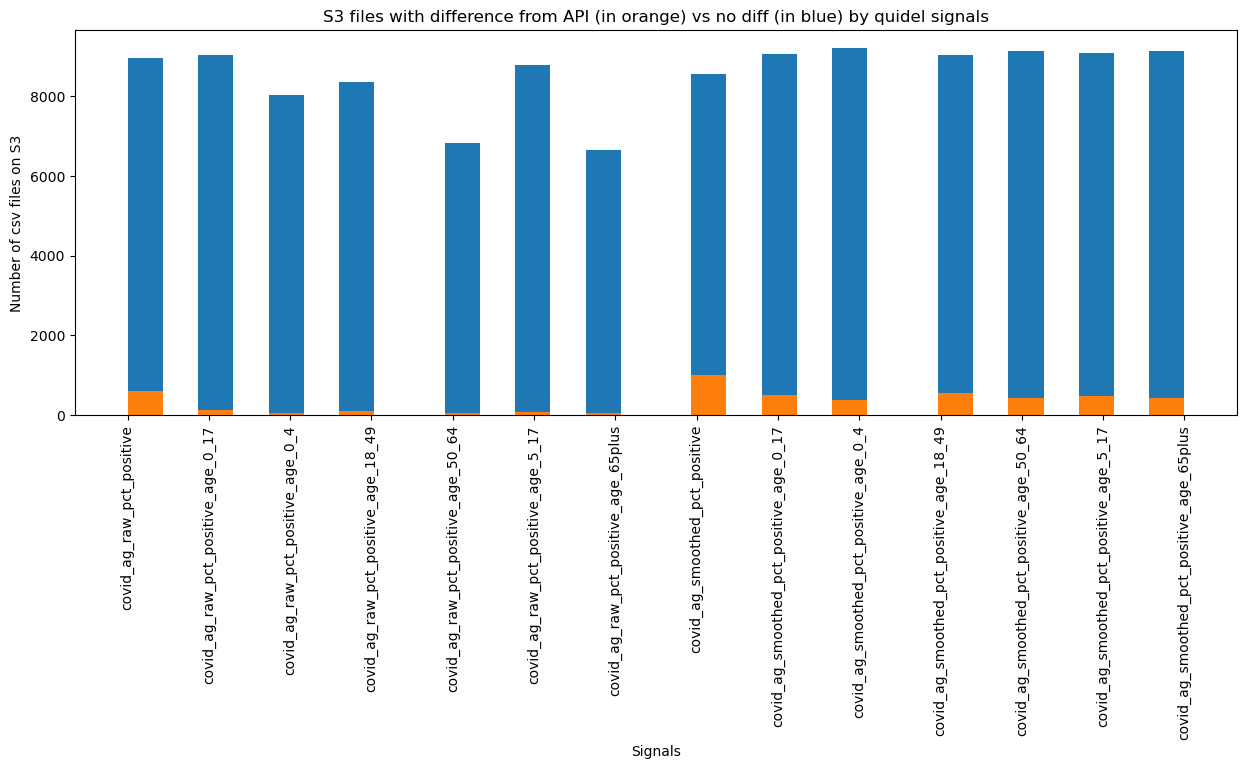

In [7]:
quidel_match = quidel[quidel['dif_row_count']==0]
quidel_diff = quidel[quidel['dif_row_count']!=0]

# Create a histogram of the 'signal' column
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.hist(quidel_match['signal'], bins=30, linestyle=':')
plt.hist(quidel_diff['signal'], bins=30,)

# Set the labels and title
plt.xlabel('Signals')
plt.ylabel('Number of csv files on S3')
plt.title('S3 files with difference from API (in orange) vs no diff (in blue) by quidel signals')
plt.xticks(rotation=90)
# Display the plot
plt.show()

/var/folders/gk/ld02_6n171z4tz6ddznd2crc0000gn/T/ipykernel_80261/2317541109.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quidel_diff['time_value'] = pd.to_datetime(quidel_diff['time_value'], format='%Y%m%d')


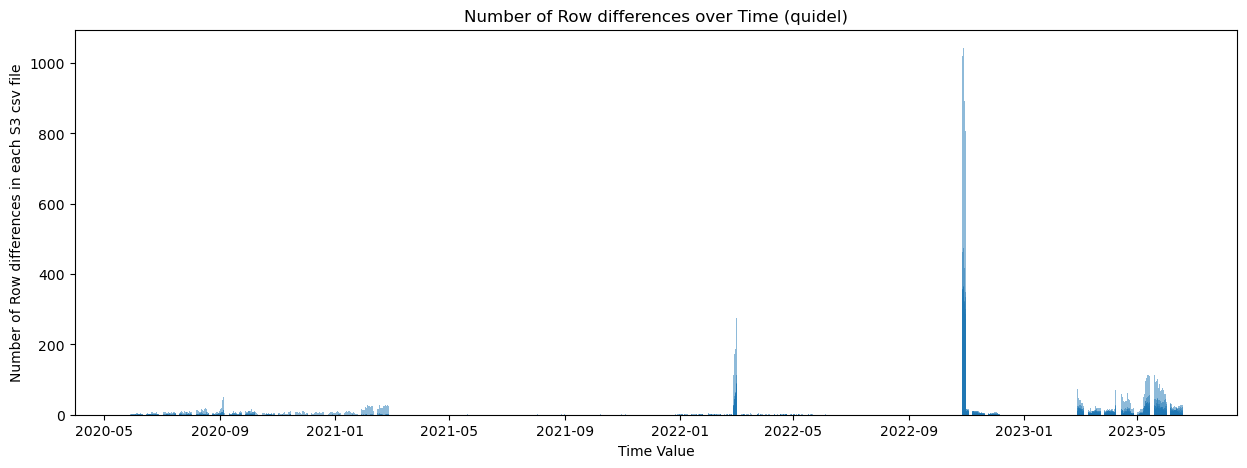

In [8]:


import matplotlib.pyplot as plt
import pandas as pd

# Convert 'time_value' to datetime
quidel_diff['time_value'] = pd.to_datetime(quidel_diff['time_value'], format='%Y%m%d')
#quidel['time_value'] = pd.to_datetime(quidel['time_value'], format='%Y%m%d')

# Create a plot
plt.figure(figsize=(15, 5))
plt.bar(quidel_diff['time_value'], quidel_diff['dif_row_count'], alpha=0.5)
#plt.bar(quidel['time_value'],  quidel['s3_row_count'], color='black', alpha=0.5)

# Set the labels and title
plt.xlabel('Time Value')
plt.ylabel('Number of Row differences in each S3 csv file')
plt.title('Number of Row differences over Time (quidel)')

# Display the plot
plt.show()

#### 2. nchs

Note: This indicator uses its own version of the archive differ, which outputs a different csv structure, causing wrong result in previous analysis.

With that and missingness taken into account, this time we see the indicator has 13% of files being different from its equivalent api result, with the biggest spike in mid 2023.

In [9]:
nchs = df[df["source"]=="nchs-mortality"]
#nchs.head(10)

In [10]:
print(len(nchs[nchs['dif_row_count']!=0]))
print(len(nchs))
print(len(nchs[nchs['dif_row_count']!=0])/len(nchs))

953
7046
0.1352540448481408


In [11]:
nchs_diff = nchs[nchs['dif_row_count']!=0]
nchs_diff = nchs_diff[nchs_diff['skip']==False]

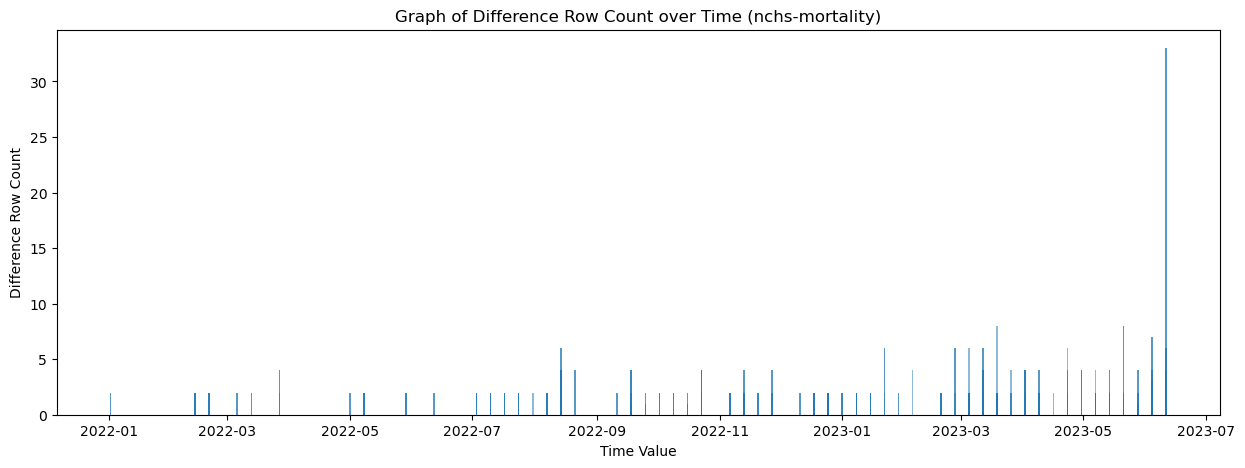

In [12]:
nchs_diff['time_value'] = nchs_diff['time_value'].astype(str) + '0'

# Convert 'time_value' to datetime
nchs_diff['time_value'] = pd.to_datetime(nchs_diff['time_value'], format='%Y%U%w')

# Create a plot
plt.figure(figsize=(15, 5))
plt.bar(nchs_diff['time_value'], nchs_diff['dif_row_count'], alpha=0.5)

# Set the labels and title
plt.xlabel('Time Value')
plt.ylabel('Difference Row Count')
plt.title('Graph of Difference Row Count over Time (nchs-mortality)')

# Display the plot
plt.show()

#### 3. chng

Around 30% of files have some differences from api.
Two major periods of mismatch:
- Mid 2020 to late 2021
- mid 2023 when the big contract patch happened.

In [13]:
chng = df[df["source"]=="chng"]
#chng.head(10)

In [14]:
print(len(chng[chng['dif_row_count']!=0]))
print(len(chng))
print(len(chng[chng['dif_row_count']!=0])/len(chng))

16174
51084
0.3166157701041422


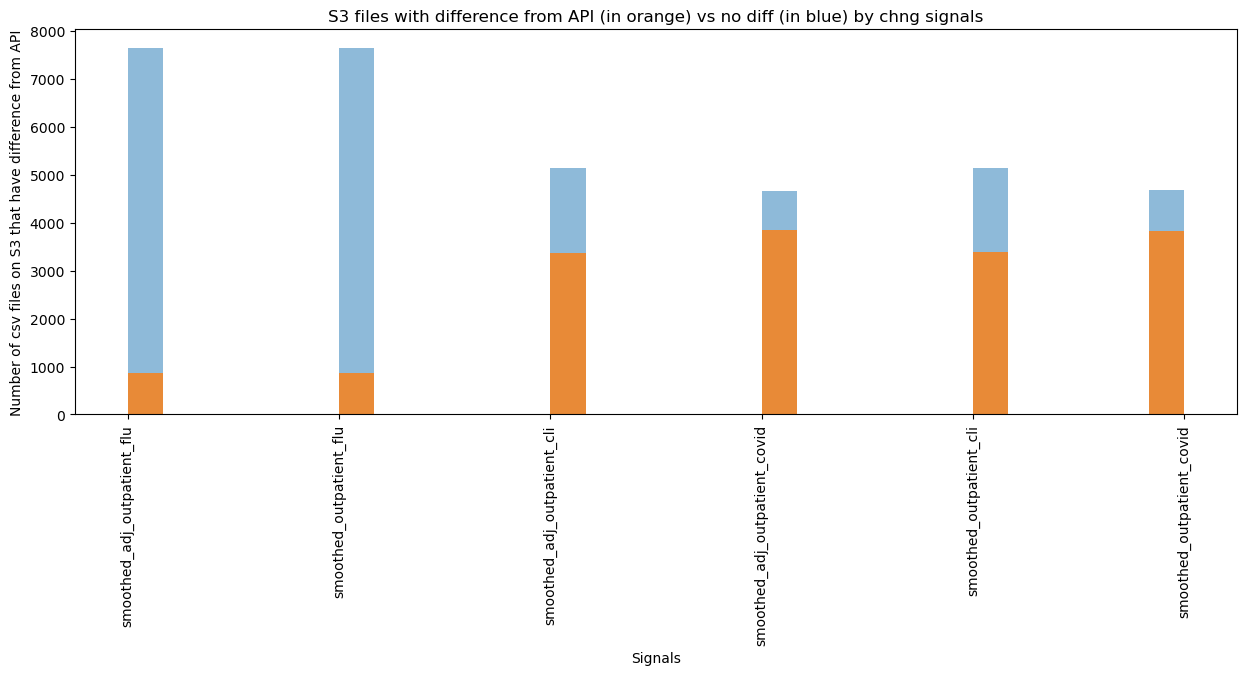

In [15]:
chng_diff = chng[chng['dif_row_count']!=0]
chng_match = chng[chng['dif_row_count']==0]

plt.figure(figsize=(15, 5))
plt.hist(chng_match['signal'], bins=30,alpha=0.5)
plt.hist(chng_diff['signal'], bins=30,alpha=0.8)

# Set the labels and title
plt.xlabel('Signals')
plt.ylabel('Number of csv files on S3 that have difference from API')
plt.title('S3 files with difference from API (in orange) vs no diff (in blue) by chng signals')
plt.xticks(rotation=90)
# Display the plot
plt.show()

/var/folders/gk/ld02_6n171z4tz6ddznd2crc0000gn/T/ipykernel_80261/3885420730.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chng_diff['time_value'] = pd.to_datetime(chng_diff['time_value'], format='%Y%m%d')
/var/folders/gk/ld02_6n171z4tz6ddznd2crc0000gn/T/ipykernel_80261/3885420730.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chng['time_value'] = pd.to_datetime(chng['time_value'], format='%Y%m%d')


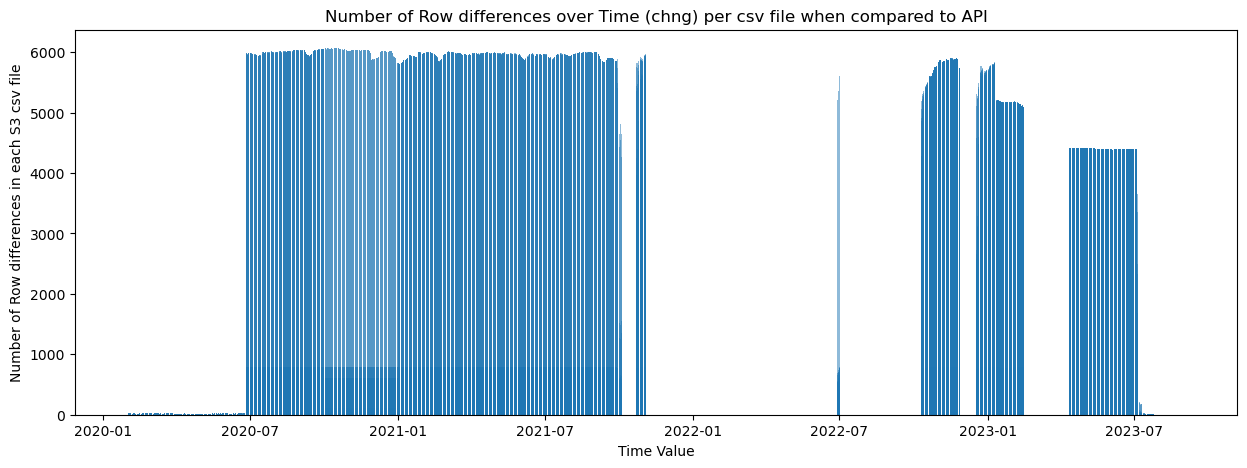

In [16]:
# Convert 'time_value' to datetime
chng_diff['time_value'] = pd.to_datetime(chng_diff['time_value'], format='%Y%m%d')
chng['time_value'] = pd.to_datetime(chng['time_value'], format='%Y%m%d')

# Create a plot
plt.figure(figsize=(15, 5))
plt.bar(chng_diff['time_value'], chng_diff['dif_row_count'], alpha=0.5)
# plt.bar(chng['time_value'], chng['s3_row_count'], alpha=0.3, color='black')

# Set the labels and title
plt.xlabel('Time Value')
plt.ylabel('Number of Row differences in each S3 csv file')
plt.title('Number of Row differences over Time (chng) per csv file when compared to API')

# Display the plot
plt.show()

#### 4.hhs
Vast majority of files for this indicator match api.
Late 2023 is when we see a spike of mismatch, right before the indicator got retired.


In [17]:
hhs= df[df["source"]=="hhs"]
# hhs.head(10)

In [18]:
print(len(hhs[hhs['dif_row_count']!=0]))
print(len(hhs))
print(len(hhs[hhs['dif_row_count']!=0])/len(hhs))

796
56736
0.014029892836999435


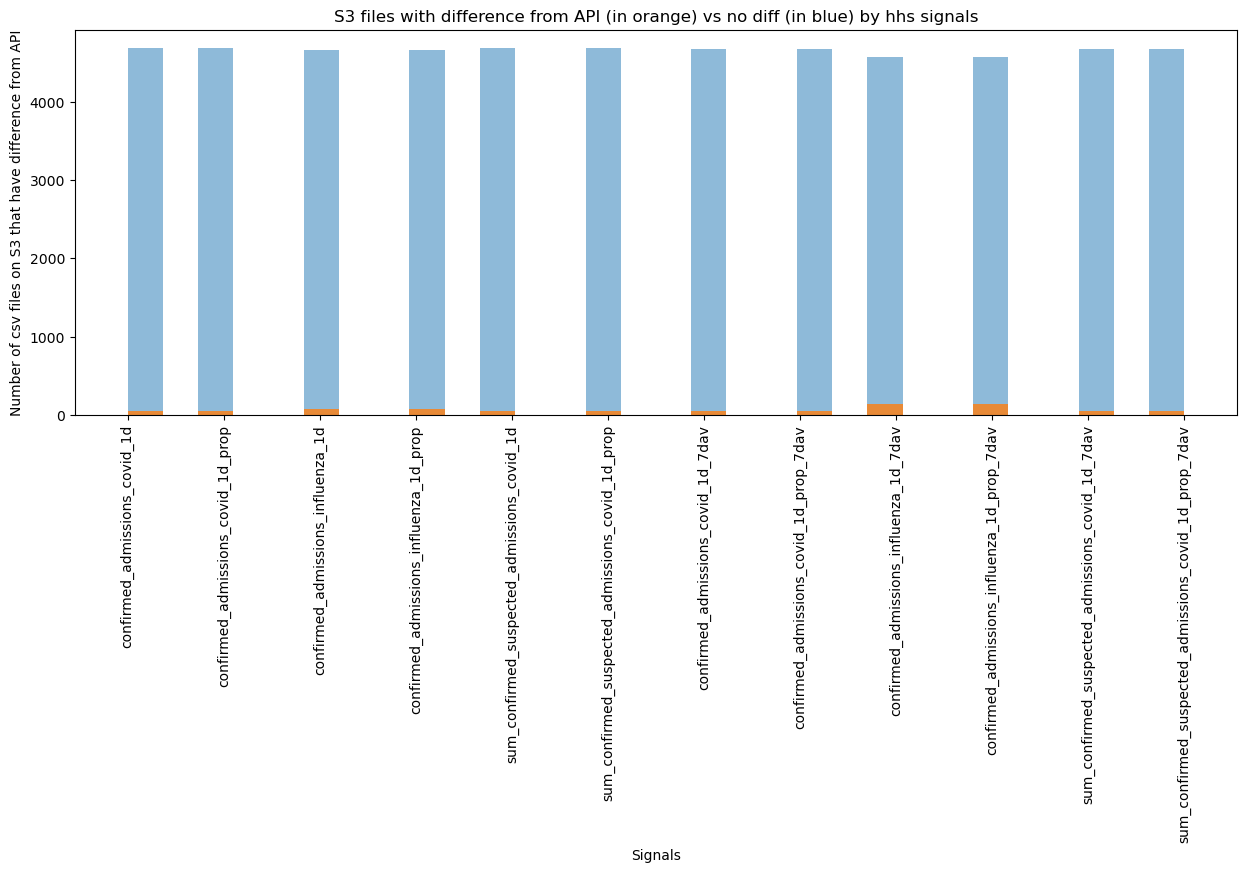

In [19]:
hhs_diff = hhs[hhs['dif_row_count']!=0]
hhs_match = hhs[hhs['dif_row_count']==0]

plt.figure(figsize=(15, 5))
plt.hist(hhs_match['signal'], bins=30, alpha=0.5)
plt.hist(hhs_diff['signal'], bins=30, alpha=0.8)

# Set the labels and title
plt.xlabel('Signals')
plt.ylabel('Number of csv files on S3 that have difference from API')
plt.title('S3 files with difference from API (in orange) vs no diff (in blue) by hhs signals')

plt.xticks(rotation=90)
# Display the plot
plt.show()

/var/folders/gk/ld02_6n171z4tz6ddznd2crc0000gn/T/ipykernel_80261/1682873475.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hhs_diff['time_value'] = pd.to_datetime(hhs_diff['time_value'], format='%Y%m%d')


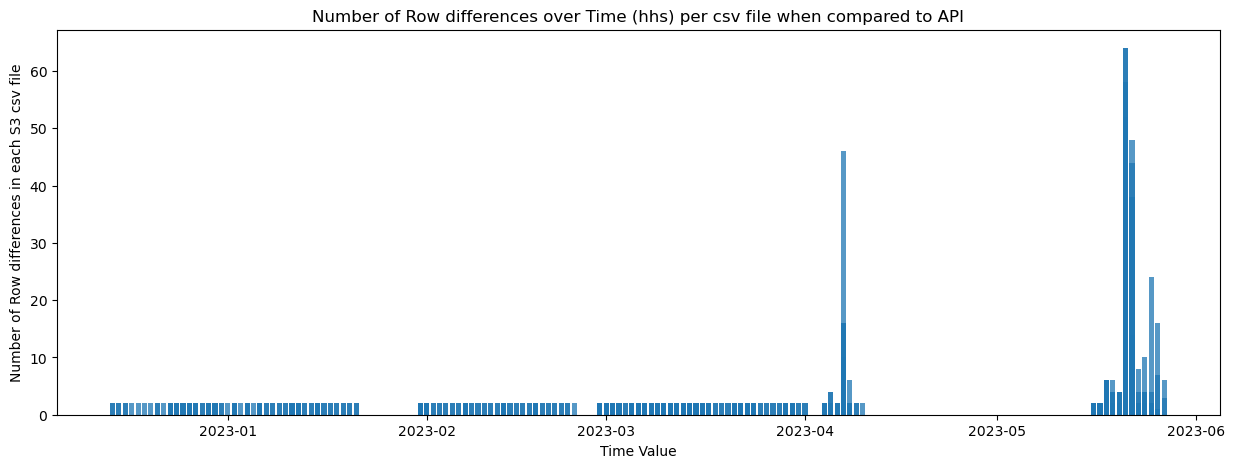

In [20]:
# Convert 'time_value' to datetime
hhs_diff['time_value'] = pd.to_datetime(hhs_diff['time_value'], format='%Y%m%d')

# Create a plot
plt.figure(figsize=(15, 5))
plt.bar(hhs_diff['time_value'], hhs_diff['dif_row_count'], alpha=0.5)

# Set the labels and title
plt.xlabel('Time Value')
plt.ylabel('Number of Row differences in each S3 csv file')
plt.title('Number of Row differences over Time (hhs) per csv file when compared to API')


# Display the plot
plt.show()

#### 5. dsew
Vast majority of the files all match. 

In [21]:
dsew = df[df["source"]=="dsew-cpr"]
#dsew.head(10)

In [22]:
print(len(dsew[dsew['dif_row_count']!=0]))
print(len(dsew))
print(len(dsew[dsew['dif_row_count']!=0])/len(dsew))

53
15651
0.003386365088492748


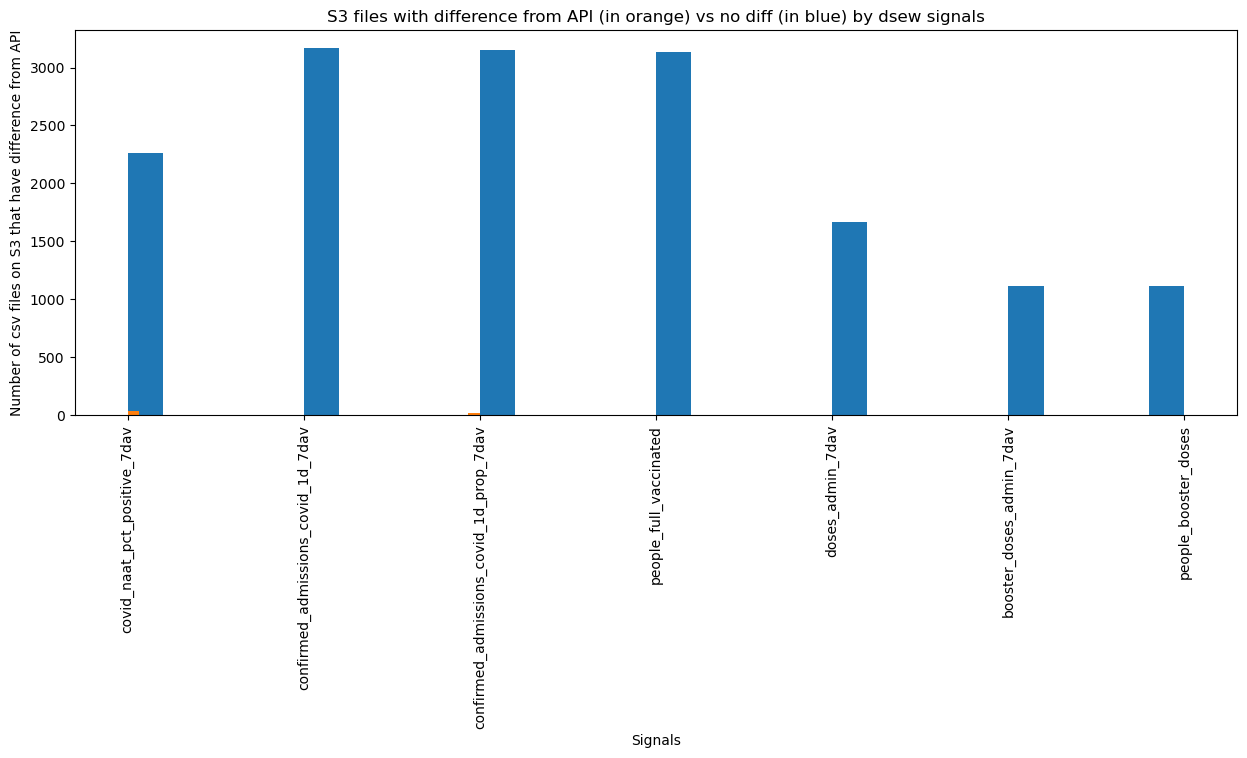

In [23]:
dsew_diff = dsew[dsew['dif_row_count']!=0]
dsew_match = dsew[dsew['dif_row_count']==0]

plt.figure(figsize=(15, 5))
plt.hist(dsew_match['signal'], bins=30, linestyle=':')
plt.hist(dsew_diff['signal'], bins=30,)

# Set the labels and title
plt.xlabel('Signals')
plt.ylabel('Number of csv files on S3 that have difference from API')
plt.title('S3 files with difference from API (in orange) vs no diff (in blue) by dsew signals')
plt.xticks(rotation=90)
# Display the plot
plt.show()

/var/folders/gk/ld02_6n171z4tz6ddznd2crc0000gn/T/ipykernel_80261/2671474670.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dsew_diff['time_value'] = pd.to_datetime(dsew_diff['time_value'], format='%Y%m%d')


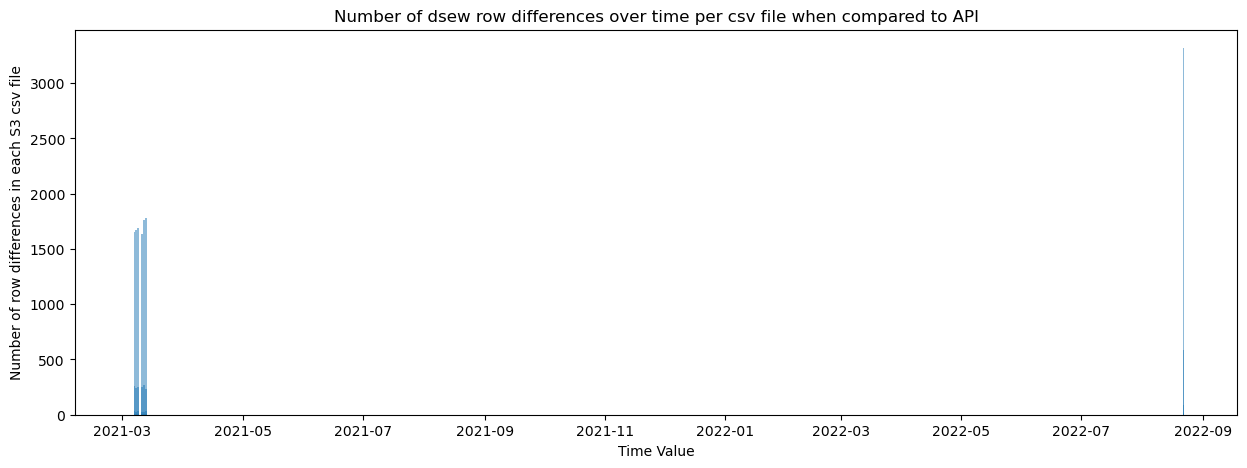

In [24]:
# Convert 'time_value' to datetime
dsew_diff['time_value'] = pd.to_datetime(dsew_diff['time_value'], format='%Y%m%d')

# Create a plot
plt.figure(figsize=(15, 5))
plt.bar(dsew_diff['time_value'], dsew_diff['dif_row_count'], alpha=0.5)

# Set the labels and title
plt.xlabel('Time Value')
plt.ylabel('Number of row differences in each S3 csv file')
plt.title('Number of dsew row differences over time per csv file when compared to API')


# Display the plot
plt.show()

#### 6. usafacts
Vast majority of files match.
Big spike for super brief periods of time in 2020.

In [25]:
usafacts = df[df["source"]=="usa-facts"]
usafacts.head()

,file_name,source,signal,time_value,geo_type,dif_row_count,s3_row_count,api_row_count,full_dif,skip,reason
166389,usafacts/20200122_county_confirmed_cumulative_...,usa-facts,confirmed_cumulative_num,20200122,county,3192.0,3192.0,0.0,1.0,False,NaN
166390,usafacts/20200122_county_confirmed_cumulative_...,usa-facts,confirmed_cumulative_prop,20200122,county,3142.0,3142.0,0.0,1.0,False,NaN
166391,usafacts/20200122_county_confirmed_incidence_n...,usa-facts,confirmed_incidence_num,20200122,county,3192.0,3192.0,0.0,1.0,False,NaN
166392,usafacts/20200122_county_confirmed_incidence_p...,usa-facts,confirmed_incidence_prop,20200122,county,3142.0,3142.0,0.0,1.0,False,NaN
166393,usafacts/20200122_county_deaths_cumulative_num...,usa-facts,deaths_cumulative_num,20200122,county,3192.0,3192.0,0.0,1.0,False,NaN


In [26]:
print(len(usafacts[usafacts['dif_row_count']!=0]))
print(len(usafacts))
print(len(usafacts[usafacts['dif_row_count']!=0])/len(usafacts))

1836
90392
0.02031153199398177


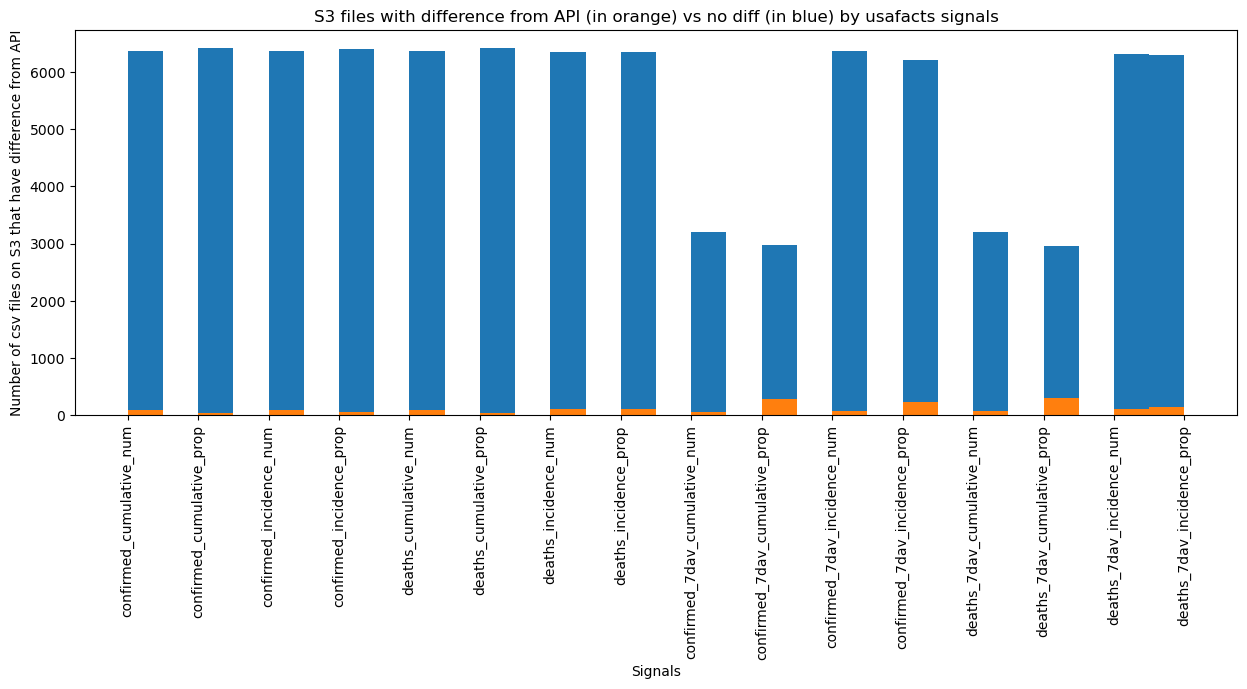

In [27]:
usafacts_diff = usafacts[usafacts['dif_row_count']!=0]
usafacts_match = usafacts[usafacts['dif_row_count']==0]

plt.figure(figsize=(15, 5))
plt.hist(usafacts_match['signal'], bins=30, linestyle=':')
plt.hist(usafacts_diff['signal'], bins=30,)

# Set the labels and title
plt.xlabel('Signals')
plt.ylabel('Number of csv files on S3 that have difference from API')
plt.title('S3 files with difference from API (in orange) vs no diff (in blue) by usafacts signals')
plt.xticks(rotation=90)
# Display the plot
plt.show()

/var/folders/gk/ld02_6n171z4tz6ddznd2crc0000gn/T/ipykernel_80261/822720485.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usafacts_diff['time_value'] = pd.to_datetime(usafacts_diff['time_value'], format='%Y%m%d')


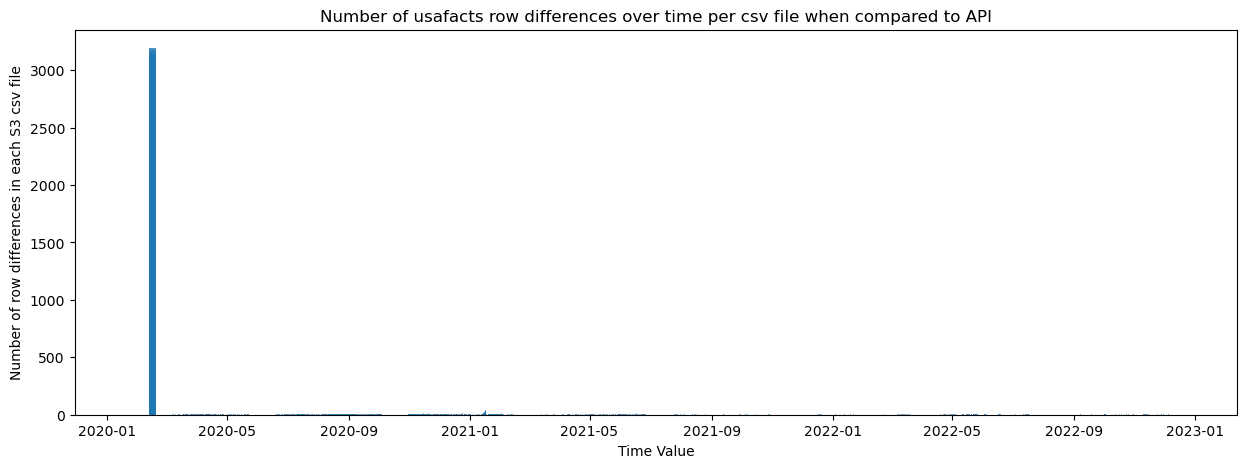

In [28]:
# Convert 'time_value' to datetime
usafacts_diff['time_value'] = pd.to_datetime(usafacts_diff['time_value'], format='%Y%m%d')
# usafacts['time_value'] = pd.to_datetime(usafacts['time_value'], format='%Y%m%d')

# Create a plot
plt.figure(figsize=(15, 5))
plt.bar(usafacts_diff['time_value'], usafacts_diff['dif_row_count'], alpha=0.5)
# plt.bar(usafacts['time_value'], usafacts['s3_row_count'], alpha=0.3, color='black')

# Set the labels and title
plt.xlabel('Time Value')
plt.ylabel('Number of row differences in each S3 csv file')
plt.title('Number of usafacts row differences over time per csv file when compared to API')


# Display the plot
plt.show()

#### 7. JHU
Around 20% of fies have mismatch. 
Big outlier spike in early 2023.

In [29]:
jhu = df[df["source"]=="jhu-csse"]
jhu.head()

,file_name,source,signal,time_value,geo_type,dif_row_count,s3_row_count,api_row_count,full_dif,skip,reason
0,jhu/20200220_county_confirmed_7dav_cumulative_...,jhu-csse,confirmed_7dav_cumulative_prop,20200220,county,4.0,3270.0,3274.0,0.0,False,NaN
1,jhu/20200220_county_confirmed_7dav_incidence_n...,jhu-csse,confirmed_7dav_incidence_num,20200220,county,4.0,3278.0,3282.0,0.0,False,NaN
2,jhu/20200220_county_confirmed_7dav_incidence_p...,jhu-csse,confirmed_7dav_incidence_prop,20200220,county,56.0,3219.0,3275.0,0.0,False,NaN
3,jhu/20200220_county_confirmed_cumulative_num.csv,jhu-csse,confirmed_cumulative_num,20200220,county,4.0,3278.0,3282.0,0.0,False,NaN
4,jhu/20200220_county_confirmed_cumulative_prop.csv,jhu-csse,confirmed_cumulative_prop,20200220,county,56.0,3219.0,3275.0,0.0,False,NaN


In [30]:
print(len(jhu[jhu['dif_row_count']!=0]))
print(len(jhu))
print(len(jhu[jhu['dif_row_count']!=0])/len(jhu))

15832
92608
0.17095715272978576


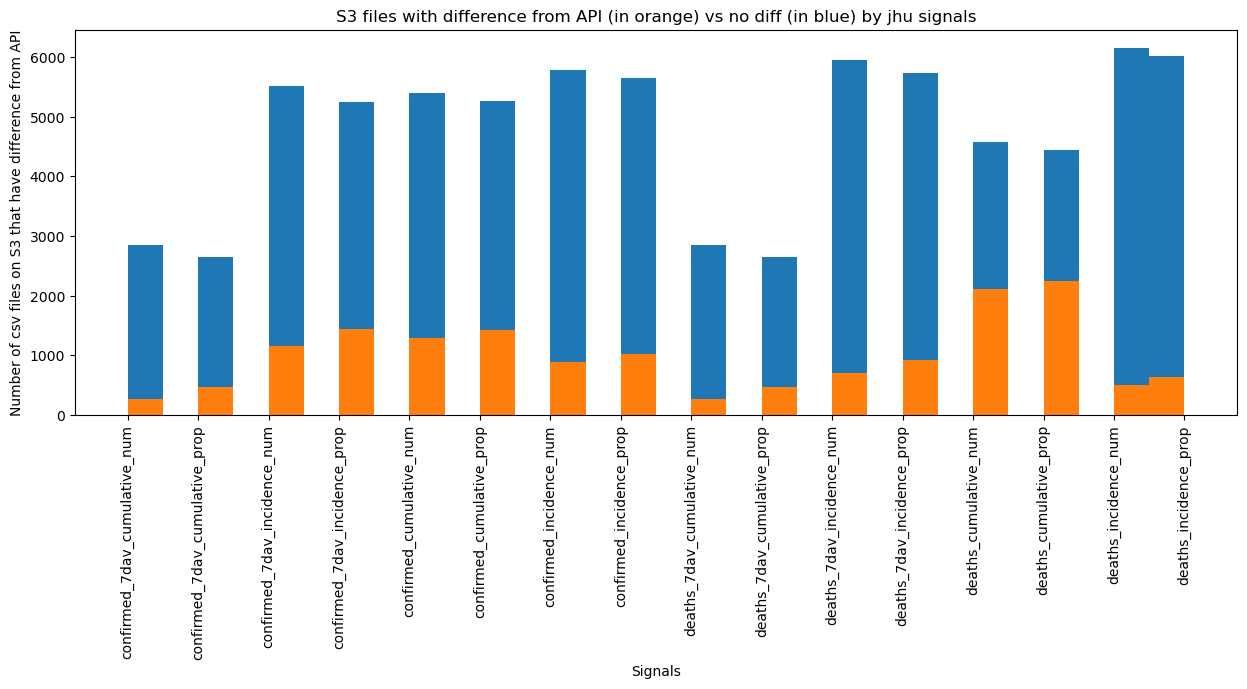

In [31]:
jhu_diff = jhu[jhu['dif_row_count']!=0]
jhu_match = jhu[jhu['dif_row_count']==0]

plt.figure(figsize=(15, 5))
plt.hist(jhu_match['signal'], bins=30, linestyle=':')
plt.hist(jhu_diff['signal'], bins=30,)

# Set the labels and title
plt.xlabel('Signals')
plt.ylabel('Number of csv files on S3 that have difference from API')
plt.title('S3 files with difference from API (in orange) vs no diff (in blue) by jhu signals')
plt.xticks(rotation=90)
# Display the plot
plt.show()

/var/folders/gk/ld02_6n171z4tz6ddznd2crc0000gn/T/ipykernel_80261/1727428579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jhu_diff['time_value'] = pd.to_datetime(jhu_diff['time_value'], format='%Y%m%d')


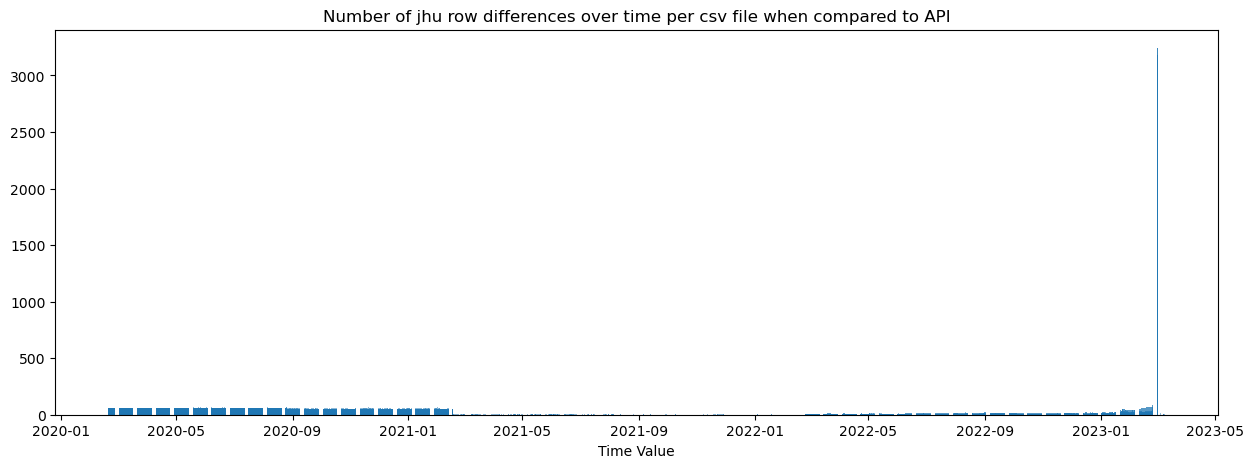

In [32]:
# Convert 'time_value' to datetime
jhu_diff['time_value'] = pd.to_datetime(jhu_diff['time_value'], format='%Y%m%d')
# jhu['time_value'] = pd.to_datetime(jhu['time_value'], format='%Y%m%d')

# Create a plot
plt.figure(figsize=(15, 5))
plt.bar(jhu_diff['time_value'], jhu_diff['dif_row_count'], alpha=0.5)
# plt.bar(jhu['time_value'], jhu['s3_row_count'], alpha=0.3, color='black')

# Set the labels and title
plt.xlabel('Time Value')
# plt.ylabel('Number of row differences in each S3 csv file')
plt.title('Number of jhu row differences over time per csv file when compared to API')

# Display the plot
plt.show()